# Building a Spam Filter with Naive Bayes

In this project, we're going to build a spam filter for SMS messages using the scikit-learn library which has the Naive Bayes algorithms. Our goal is to see how a built-in program classifies new messages with an accuracy greater than 80%, we will then compare the results with the one we got from scratch.

In the other [notebook](SMS-Spam-Filter-from-Scratch.ipynb) we wrote functions from scratch to train the multinomial Naive Bayes algorithm.  While this is a helpful deliberate practice to understand how the mechanics work, you can be more productive and iterate quicker by using a library that handles most of the implementation. In this notebook, we'll learn about the scikit-learn library, which is the most popular machine learning library in Python. Scikit-learn contains functions for all of the major machine learning algorithms and a simple, unified workflow. Both of these properties allow data scientists to be incredibly productive when training and testing different models on a new dataset.

## Exploring and Cleaning the Dataset

We'll start by reading in the dataset and do some exploration before moving on to some data cleaning.

In [1]:
# import libraries
import pandas as pd
import numpy as np

sms_spam = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label', 'SMS'])

print(sms_spam.shape)
sms_spam.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Let's get some information about our dataset.

In [2]:
sms_spam.info() # get some information on our dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


We don't have any missing values. Let's check if we have duplicates.

In [3]:
# check for duplicates
sms_spam.duplicated().sum()

403

The dataset has 403 duplicates. Let's remove them.

In [4]:
# removing duplicate
sms_spam = sms_spam.drop_duplicates(keep='first')
print(sms_spam.shape)
sms_spam.head()

(5169, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Let's find out what percentage of the messages are spam and what percentage are ham ("ham" means non-spam)

In [5]:
sms_spam['Label'].value_counts(normalize=True)

ham     0.87367
spam    0.12633
Name: Label, dtype: float64

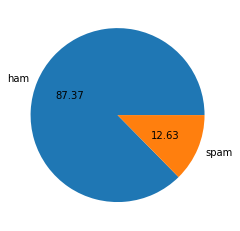

In [6]:
# Let's visualise the Label column
import matplotlib.pyplot as plt
plt.pie(sms_spam['Label'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

We see that about 87% of the messages are ham, and the remaining 13% are spam. This sample looks representative, since in practice most messages that people receive are ham. Also, this means that the dataset is imbalanced, were one classification is more represented than the other one. In serious situations this imbalance can cause problems where the algorithm may have poor performance in predictions, specifically for the minority  class. However, in our case since the sample is representative the algorithm should perform well.

## Data Transformation

Our next task now is to transform the data in the way it can be used as input by the algorithm.

Essentialy, we want to bring the data to this kinda format:

![img](cpgp_dataset_3.png)


### Encoding the Label target column

We'll begin with encoding the Label columns to 0 (for ham) and 1 (for spam).

In [7]:
# import library
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

#Encode the label column
sms_spam['Label'] = encoder.fit_transform(sms_spam['Label']) 
sms_spam.head()

,Label,SMS
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


To continue with the transformation of our data, specifically the SMS column. We will use a module called **nltk** (Natural Language Toolkit). NLTK is a leading platform for building Python programs to work with human language data. You can read more about it [here](https://www.nltk.org/).

With the nltk module, we're going to a create function which will do the following:

- Lower case -- convert the texts to lower case
- Tokenization -- Tokenizing means splitting your text into minimal meaningful units. As in converts text message to a list of individual strings.
- Remove special characters 
- Remove stopwords and punctuation -- Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence.
- Stemming -- This is the process of producing morphological variants of a root/base word, e.g. converts 'loving' to 'love'.

In [8]:
# import nltk library and download modules
import nltk

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dintoe_T\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dintoe_T\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# import libraries
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
ps.stem('loving') # example

'love'

In [10]:
def transform_text(text):
    text = text.lower() # converts text to lowercase
    text = nltk.word_tokenize(text) #split text to a list of strings
    
    y = []
    for i in text:  # removing special characters
        if i.isalnum():
            y.append(i)
            
    text = y[:] # reassign y and reset it
    y.clear() 
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:] # reassign y and reset it
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
                        
    return " ".join(y)

We now use the transform_text function to our sms_spam data.

In [11]:
sms_spam['transformed_sms'] = sms_spam['SMS'].apply(transform_text)
sms_spam.head()

,Label,SMS,transformed_sms
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


In [12]:
sms_spam['SMS'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

Let's view the most frequent spam words via the Wordcloud module. This lets us have a visual look at the most frequent words in the spam and ham messages. 

We begin by looking at the spam messages.

In [13]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white', random_state=1)

spam_wc = wc.generate(sms_spam[sms_spam['Label'] == 1]['transformed_sms'].str.cat(sep=" "))

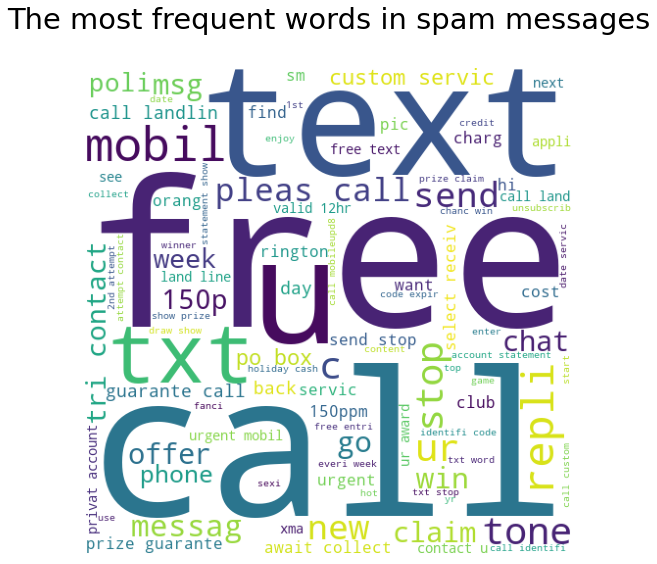

In [14]:
# Generate the wordcloud image
plt.figure(figsize=(15,9))
plt.title('The most frequent words in spam messages\n', fontsize=29)
plt.imshow(spam_wc)
plt.axis('off')
plt.show()

We lastly look at the ham messages wordcloud.

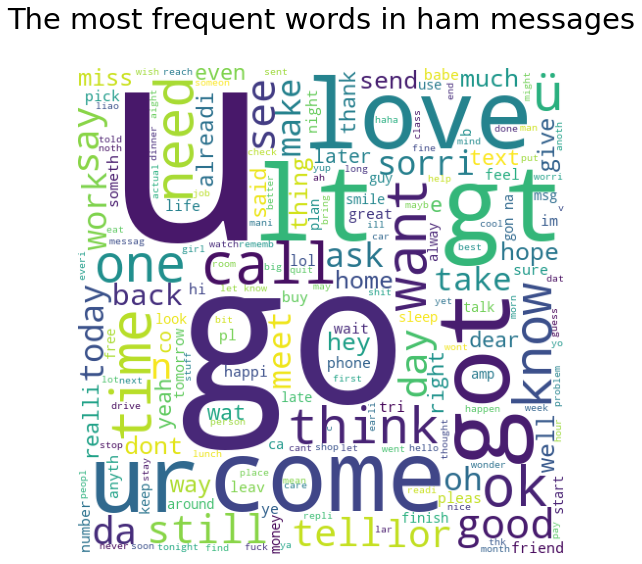

In [15]:
# ham wordcloud
# Generate the wordcloud image
plt.figure(figsize=(15,9))
ham_wc = wc.generate(sms_spam[sms_spam['Label'] == 0]['transformed_sms'].str.cat(sep=" "))
plt.title('The most frequent words in ham messages\n', fontsize=29)
plt.imshow(ham_wc)
plt.axis('off')
plt.show()

Based on the wordclouds for the spam and ham classifications. We can see that there's contrast between the two. Spam has urging, action, attempting words etc. whereas ham doesn't.
We can count the words and see the most frequent ones.

In [16]:
# List to count most frequent spam message
spam_corpus = []
for msg in sms_spam[sms_spam['Label'] == 1]['transformed_sms'].tolist(): # converts the transformed_sms column to a list
    for word in msg.split():
        spam_corpus.append(word)
        
len(spam_corpus)        

9982

In [17]:
# We do the same for ham messages
# List to count most frequent spam message
ham_corpus = []
for msg in sms_spam[sms_spam['Label'] == 0]['transformed_sms'].tolist(): # converts the transformed_sms column to a list
    for word in msg.split():
        ham_corpus.append(word)
        
len(ham_corpus) 

35937

Wow! Ham classifier has 35937 words and spam 9982.

Now we look at bar graphs of the count of the most frequent word.

C:\Users\Dintoe_T\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


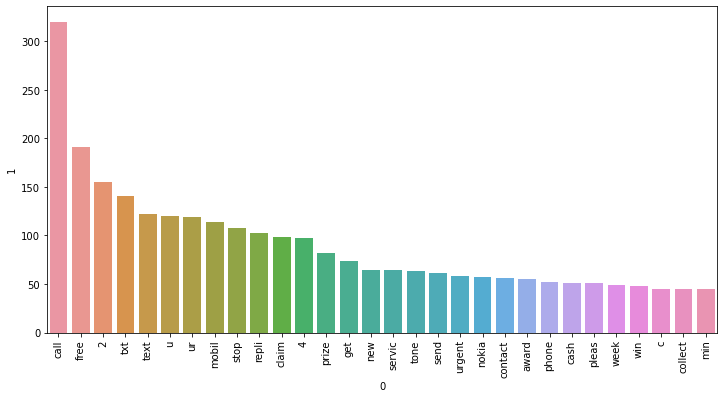

In [18]:
# import libraries
import seaborn as sns
from collections import Counter

# Bar graph for spam messages
plt.figure(figsize=(12,6))
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0], pd.DataFrame(Counter(spam_corpus).most_common(30))[1]) # convert count of words to a dict and plot top 30
plt.xticks(rotation='vertical')
plt.show()

C:\Users\Dintoe_T\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


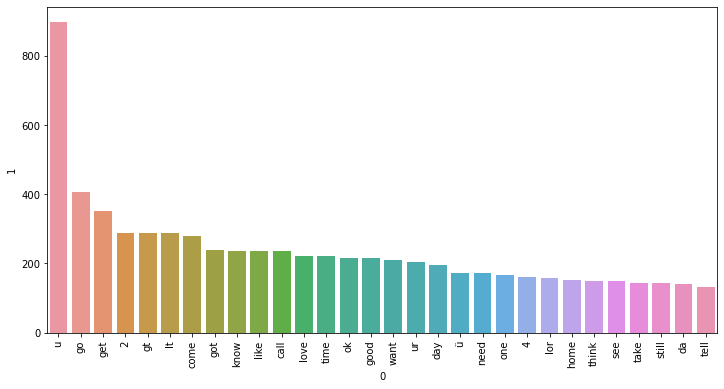

In [19]:
# Bar graph for spam messages
plt.figure(figsize=(12,6))
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[0], pd.DataFrame(Counter(ham_corpus).most_common(30))[1]) # convert count of words to a dict and plot top 30
plt.xticks(rotation='vertical')
plt.show()

## The Final Transformation step

We've done enough exploration, it's time we build the transformation we wanted.

In [20]:
# import libraries
from sklearn.feature_extraction.text import CountVectorizer  #,TfidfVectorizer
cv = CountVectorizer()

In [21]:
X = cv.fit_transform(sms_spam['transformed_sms']).toarray()
# Selecting the y target
y = sms_spam['Label'].values


Our dataset is now ready to be fed to the algorithms. We will now split the dataset into training and testing sets.

In [22]:
#  import libraries
from sklearn.model_selection import train_test_split

# Split-out validation dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

## Building the Spam filter

We're now going to build the spam filters using 4 Naive Bayes models to see which one performs better. The four models are multinomial Naive Bayes (MultinomialNB), GaussianNB, BernoulliNB and ComplementNB. The ComplementNB model is for handling imbalanced data sets.

In [23]:
# loading libraries
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

# preparing the models

# models = []
# models.append(('GNB', GaussianNB()))
# models.append(('MNB', MultinomialNB()))
# models.append(('CNB', ComplementNB()))
# models.append(('BNB', BernoulliNB()))

gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
cnb = ComplementNB()

# evaluate each model in turn
# results = []
# names = []
# scoring = 'accuracy'
# for name, model in models:
#     model.fit(X_train, y_train)
#     result = model.score(X_test, y_test)
#     results.append(result)
#     names.append(name)
#     msg = "{0}: {1} ({2})".format(name, result.mean(), result.std())
#     print(msg)


In [24]:
# evaluation of GNB model
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8549323017408124
[[770 136]
 [ 14 114]]
0.456


In [25]:
# evaluation of MNB model
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.971953578336557
[[888  18]
 [ 11 117]]
0.8666666666666667


In [26]:
# evaluation of BNB model
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9748549323017408
[[903   3]
 [ 23 105]]
0.9722222222222222


From the accuracy scores we see that MultinomialNB and BernoulliNB perform the best with scores of 97.2% and 97.48% respectively. However, MultinomialNB is the best with only 11 messages incorrectly classified compared to BernoulliNB with 23.

# Conclusion

We have successfully build an SMS spam classifier by fitting a few different Naive Bayes models on out dataset. We concluded that the MultinomialNB is the best model with an accuracy of 97.2% and only just 11 misclassifications.

In comparison to the build from model we did with an accuracy of 98.7%, the scikit learn MultinomialNB though has less score but it out performs the scratch one with less misclassifications.